<h1 align=center>Media Topic Tracking</h1>
<h2 align=center>Using Natural Language Processing</h2>
<h2 align=center>and</h2>
<h2 align=center>Machine Learning</h2>

### Sentiment Analysis

Sentiment analysis is the attempt to quantify the tone of the text through the words in the text.  There are many sentiment analyzers available to Python developers.  In this notebook I chose to use TextBlob.  TextBlob evaluates sentiment on two scales.  Polarity is ranked on a scale from -1 to 1.  Subjectivity is ranked on a scale from 0 to 1, 0 being neutral and 1 be subjective.

In [1]:
# Import the modules we will need.
import sys
import re
import os.path
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import path

from pymongo import MongoClient

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

from spacy.lang.en import English

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


In [4]:
import re
import string
import datetime as dt

from datetime import datetime, timedelta


In [5]:
# Open a link to MongoDB
db_client = MongoClient()

# The database is news search.  There are several collections within the news search db.
db_news = db_client['news_search']
db_news_col = db_news['search_result']
db_news_content = db_news['news_content']

## Sentiment Analysis

In [6]:
# Start off by making lists of the polarity and subjectivity scores for each article.
polarity_list = []
subjectivity_list = []
date_list = []

# Create a list to all the article
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'sentiment':1, 'dt_pub_date':1})
for article in list(cursor) :
    # Get the sentiment entry for each document
    sentiment = article['sentiment']
    
    # Append the scores to the list
    polarity_list.append(sentiment[0])
    subjectivity_list.append(sentiment[1])
    
    # Get the date and append it to a separate list for the dates
    date_list.append(article['dt_pub_date'])
    
max(polarity_list), min(polarity_list), max(subjectivity_list), min(subjectivity_list)

(1.0, -0.6999999999999998, 1.0, 0.0)

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


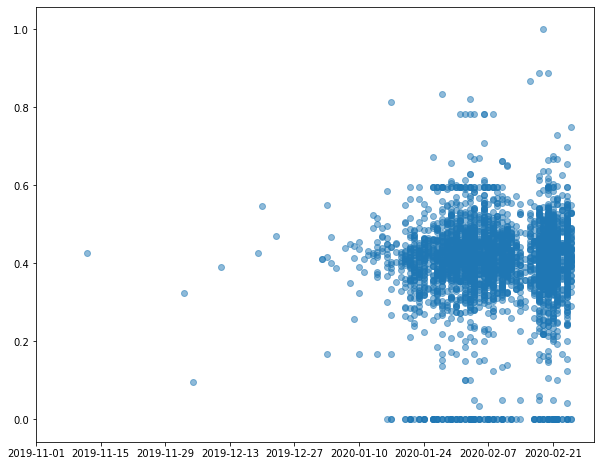

In [7]:
# Plot the scatter of the subjectivity scores
fig = plt.figure(figsize=[10, 8])

# Limit the date range to the last few months of 2019 and early 2020
t = np.arange(datetime(2019,11,1), datetime(2020,3,1), timedelta(days=14)).astype(datetime)
plt.xlim(datetime(2019, 11, 1), datetime(2020, 3, 1))
plt.xticks(t)

plt.scatter(date_list, subjectivity_list, alpha=0.5)

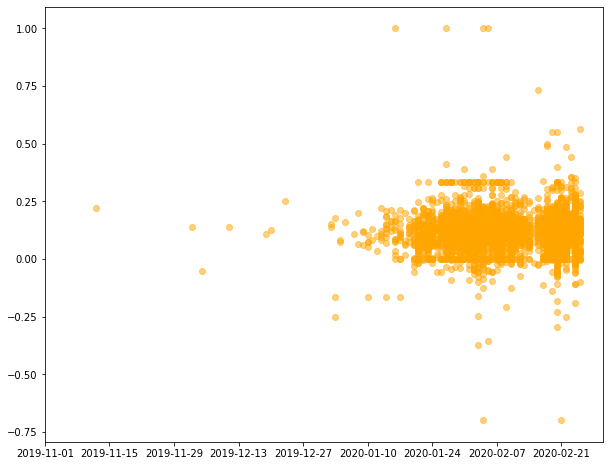

In [8]:
# Plot the scatter of the polarity scores
fig = plt.figure(figsize=[10, 8])

# Limit the date range to the last few months of 2019 and early 2020
t = np.arange(datetime(2019,11,1), datetime(2020,3,1), timedelta(days=14)).astype(datetime)
plt.xlim(datetime(2019, 11, 1), datetime(2020, 3, 1))
plt.xticks(t)

plt.scatter(date_list, polarity_list, alpha=0.5, c='orange')


Look into Text Blob sentiment analysis

(array([1.560e+02, 3.500e+01, 1.750e+02, 1.157e+03, 1.858e+03, 3.670e+02,
        3.000e+01, 1.000e+01, 6.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

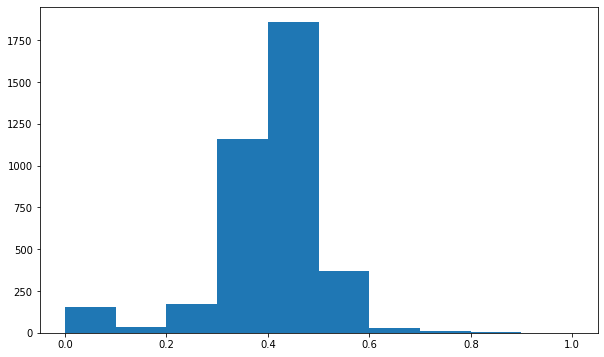

In [9]:
# Plot the distribution of the subjectivity scores
fig = plt.figure(figsize=[10, 6])

plt.hist(subjectivity_list)

(array([2.000e+00, 1.000e+00, 7.000e+00, 8.900e+01, 2.675e+03, 9.400e+02,
        7.200e+01, 4.000e+00, 1.000e+00, 4.000e+00]),
 array([-0.7 , -0.53, -0.36, -0.19, -0.02,  0.15,  0.32,  0.49,  0.66,
         0.83,  1.  ]),
 <a list of 10 Patch objects>)

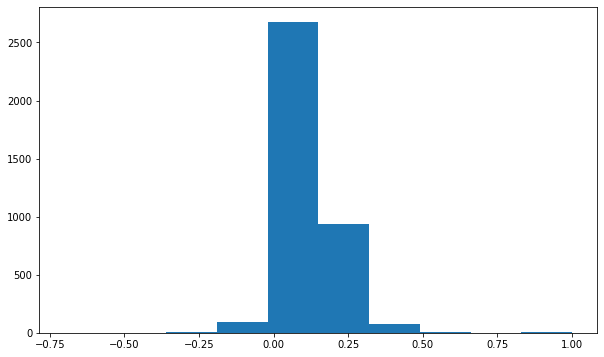

In [10]:
# Plot the distribution of the polarity scores
fig = plt.figure(figsize=[10, 6])

plt.hist(polarity_list)

### Sentiment and Location Analysis

Let's take a quick look at the sentiment with respect to geography.  

In [11]:
db_news_sources = db_news['pub_locations']

In [16]:
# Use the database with the publisher information to get the lattitude and longitude of each publisher.
# And then combine those with the sentiment scores for that publisher.
lat_list = []
lng_list = []
publishers = []

sent_polarity_aves = []
sent_subjectivity_aves = []
sent_colors = []

# Get a list of all the publishers
cursor = db_news_sources.find({}, {'_id':1, 'name':1, 'address':1, 'zip':1, 'googID': 1, 'lat':1, 'lng':1})
pub_list = list(cursor)

# For each publisher
for pub in pub_list :
    
    sentiment_polarity_list = []
    sentiment_subjectivity_list = []
    
    # Save the lattitude and longitude
    lat_list.append(pub['lat'])
    lng_list.append(pub['lng'])
    publishers.append(pub['name'])
    
    # Get all the articles published by that publisher
    article_cur = db_news_content.find({'base_url':pub['name']}, {'_id':0, 'sentiment':1})
    for article in list(article_cur) :
        # Create a list of the sentients for that publisher
        sentiment_polarity_list.append(article['sentiment'][0])
        sentiment_subjectivity_list.append(article['sentiment'][1])
        
    if len(sentiment_polarity_list) > 0 :
        sent_polarity_aves.append(np.mean(sentiment_polarity_list))
        sent_subjectivity_aves.append(np.mean(sentiment_subjectivity_list))

In [17]:
# Set the colors for the map
polar_color_pick = lambda y : 'red' if y < -0.5 else ('yellow' if y < 0.0 else ('green' if y > 0.5 else ( 'blue' if y > 0 else  'black')))
sent_colors = [polar_color_pick(z) for z in sent_polarity_aves]

In [18]:
# Import folium for printing maps
import folium
from folium.plugins import HeatMap
import numpy as np

# Generate a base map of the entire US
def generateBaseMap(default_location=[np.mean(lat_list), np.mean(lng_list)], default_zoom_start=4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

basemap = generateBaseMap()

# Put the publisers along with the color coding for their sentiment scores
for lat,lon,publisher,color in zip(lat_list,lng_list,publishers, sent_colors):
     folium.CircleMarker([lat, lon],
                            popup=publisher,
                            color=color,
                            fill=True,
                            fill_opacity=0.7,
                            radius=4,
                           ).add_to(basemap)
basemap

